In [33]:
%load_ext autoreload
%autoreload 2

import pandas as pd 
import numpy as np 
from sklearn.metrics import precision_recall_fscore_support, classification_report,confusion_matrix, precision_recall_curve, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import utils  
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import math
import torch
from scipy.io import arff
from sklearn.datasets import make_classification
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, RobustScaler
from utils import set_seed, split_data, split_vector
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from training import NonStrategicTrainer, Data, test_strategic, StrategicTrainer, IterativeCausalStrategicTrainer, IterativeNonStrategicTrainer, IterativeStrategicTrainer, CausalStrategicTrainerWithU
from model import cross_entropy_loss_for_h, hinge_loss, MLP, HelperModel
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from distribution import SequentialDistribution
from utils import create_Y, local_seed, ExplorationParams, HiddenPrints
from delta import QuadraticCostDelta, create_cost_functions
from plot_data import plot_coefs
from testing import test_strategic, test, test_strategic_only_X2_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def load_spam_data(seed, features_order=None):
    set_seed(seed)
    path = "./datasets/journalApontadorElsevier.arff"
    data, meta = arff.loadarff(path)
    df = pd.DataFrame(data)
    most_disc = ['qTips_plc', 'rating_plc', 'qEmail_tip', 'qContacts_tip', 'qURL_tip', 'qPhone_tip', 'qNumeriChar_tip', 'sentistrength_tip', 'combined_tip', 'qWords_tip',
                 'followers_followees_gph', 'qUnigram_avg_tip', 'qTips_usr', 'indeg_gph', 'qCapitalChar_tip', 'class1']

    df = df[most_disc]
    df["class1"].replace({b'spam': -1, b'notspam': 1}, inplace=True)
    df = df.sample(frac=1, random_state=seed).reset_index(drop=True)

    Y = df['class1'].values
    X = df.drop('class1', axis=1).values

    x_dim = len(X[0])
    X -= np.mean(X, axis=0)
    X /= np.std(X, axis=0)
    X /= math.sqrt(x_dim)
    # change column order
    if features_order:
        X = X[:, features_order]
    return torch.from_numpy(X).float(), torch.from_numpy(Y).float()

### linear model on the original data

In [3]:
set_seed(0)
X, Y = load_spam_data(0)
X.shape, Y.shape

(torch.Size([7076, 15]), torch.Size([7076]))

In [4]:
# split train-test
X_train, Y_train, X_test, Y_test = split_data(X, Y, 0.2)
# train linear model
lr = LogisticRegression(random_state=0).fit(X_train, Y_train)
preds = lr.predict(X_test)
acc = accuracy_score(Y_test, preds)
print(f"linear model acc: {acc}")

linear model acc: 0.8091872791519434


In [5]:
# correlation matrix
df = pd.DataFrame(data = torch.concat([Y_train.view(-1, 1), X_train], 1).numpy(), columns = ['y'] + [f"x{i}" for i in range(X.shape[1])])
corr_matrix = df.corr().abs()
corr_matrix.style.background_gradient(cmap ='viridis').set_properties(**{'font-size': '10px'})

,y,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14
y,1.000000,0.099258,0.547470,0.304659,0.341868,0.165375,0.278941,0.266906,0.295224,0.293539,0.223507,0.133228,0.042016,0.011712,0.101724,0.150846
x0,0.099258,1.000000,0.165792,0.001972,0.039318,0.047480,0.051661,0.076731,0.041643,0.039486,0.055584,0.298709,0.171187,0.145200,0.067038,0.061517
x1,0.547470,0.165792,1.000000,0.254981,0.271437,0.106905,0.214549,0.222472,0.254382,0.236651,0.203962,0.071469,0.059194,0.050572,0.060632,0.116350
x2,0.304659,0.001972,0.254981,1.000000,0.688019,0.103502,0.356729,0.369016,0.084242,0.067583,0.223832,0.005538,0.042236,0.014715,0.016404,0.192351
x3,0.341868,0.039318,0.271437,0.688019,1.000000,0.119369,0.923384,0.814883,0.077982,0.045590,0.280768,0.087199,0.182290,0.082003,0.004412,0.379270
x4,0.165375,0.047480,0.106905,0.103502,0.119369,1.000000,0.098914,0.082679,0.007314,0.024761,0.023370,0.007533,0.107479,0.017853,0.009772,0.012897
x5,0.278941,0.051661,0.214549,0.356729,0.923384,0.098914,1.000000,0.853823,0.055826,0.022939,0.243040,0.115183,0.212323,0.097780,0.002997,0.386495
x6,0.266906,0.076731,0.222472,0.369016,0.814883,0.082679,0.853823,1.000000,0.028552,0.002511,0.383962,0.088021,0.184953,0.092316,0.000668,0.486553
x7,0.295224,0.041643,0.254382,0.084242,0.077982,0.007314,0.055826,0.028552,1.000000,0.745214,0.139084,0.013904,0.032882,0.048688,0.076454,0.016516
x8,0.293539,0.039486,0.236651,0.067583,0.045590,0.024761,0.022939,0.002511,0.745214,1.000000,0.054411,0.025251,0.026098,0.051760,0.088070,0.005680


### split features

In [6]:
total_dim = 15
x1_features = [1, 8, 5] 
x2_features = [2, 3] 
u_features = x2_features + list(set([i for i in range(total_dim)]) - set(x1_features) - set(x2_features))
features_order = x1_features + u_features
x1_dim = len(x1_features)
x2_dim = len(x2_features)
# u_dim = len(u_features)
u_dim = total_dim - x1_dim


def load_data(seed):
    X, Y = load_spam_data(seed, features_order)
    X = X[:, :x1_dim + u_dim]
    return X, Y

In [7]:
set_seed(0)
A = torch.rand(x2_dim, x2_dim)

def u_to_x2(U):
    # keep only x2 features
    X2 = U[:, :x2_dim]
    # linear transform
    batch_matrix = A.expand(X2.shape[0], X2.shape[1], X2.shape[1])
    batch_vectors = torch.unsqueeze((X2), 2)
    X2 = torch.bmm(batch_matrix, batch_vectors)
    X2 = torch.squeeze(X2, 2)

    return X2

### test linear model on original data, splited

In [8]:
# load data
set_seed(0)
X, Y = load_data(0)
# split train-test
X_train, Y_train, X_test, Y_test = split_data(X, Y, 0.2)

In [9]:
X1_train, U_train = split_vector(X_train, x1_dim)
X1_test, U_test = split_vector(X_test, x1_dim)
X2_train, X2_test = u_to_x2(U_train), u_to_x2(U_test)
X1X2_train, X1X2_test = torch.concat([X1_train, X2_train], 1), torch.concat([X1_test, X2_test], 1) 

In [10]:
# train linear model only x1
lr = LogisticRegression(random_state=0).fit(X1_train, Y_train)
preds = lr.predict(X1_test)
acc = accuracy_score(Y_test, preds)
print(f"linear model acc: {acc}")

linear model acc: 0.7575971731448763


In [11]:
# train linear model only x2
lr = LogisticRegression(random_state=0).fit(X2_train, Y_train)
preds = lr.predict(X2_test)
acc = accuracy_score(Y_test, preds)
print(f"linear model acc: {acc}")

linear model acc: 0.6749116607773852


In [12]:
# train linear model on x1,x2
lr = LogisticRegression(random_state=0).fit(X1X2_train, Y_train)
preds = lr.predict(X1X2_test)
acc = accuracy_score(Y_test, preds)
print(f"linear model acc: {acc}")

linear model acc: 0.7795053003533569


### create h*

In [13]:
# load data
set_seed(0)
X, Y = load_data(0)
# split train-test
X_train, Y_train, X_test, Y_test = split_data(X, Y, 0.2)
X_train, Y_train, X_val, Y_val = split_data(X_train, Y_train, 0.4)

In [14]:
# learning params
batch_size = 64
lr = 0.01
epochs = 100
tau = 4

In [15]:
h_star_train_ds = TensorDataset(X_train, Y_train)
h_star_train_dl = DataLoader(h_star_train_ds, batch_size=batch_size, shuffle=True)
# h_star = MLP(in_dim=x1_dim + u_dim, out_dim=1, hidden_dim=10, hidden_layers=3)
h_star = nn.Linear(x1_dim + u_dim, 1)
opt = Adam(h_star.parameters(), lr=0.001)
trainer = NonStrategicTrainer(h_star, h_star_train_dl, X_val, Y_val, X_test, Y_test, opt, cross_entropy_loss_for_h)
trainer.train(100, early_stop=10)
print("\nh_star creation:")
trainer.test()

trained 99 epochs. val acc: 0.8387809187279152

h_star creation:
	Accuracy: 0.8127208480565371


0.8127208480565371

In [16]:
# # save model
# path = "saved_models/spam_h_star.pt"
# torch.save(h_star, path)

In [17]:
# # load model
# h_star = torch.load(path)

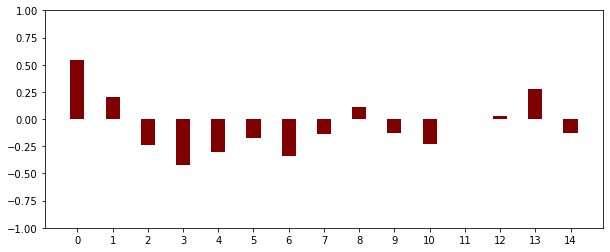

In [18]:
# calculate gradient with respect to input
grads_list = []
for i in range(len(X_train)):
    x = X_train[i]
    x.requires_grad = True
    out = h_star(x)
    grads_list.append(torch.autograd.grad(out, x, retain_graph=True)[0].data.view(1, -1))
    
grads = torch.concat(grads_list, 0)
grads_mean = grads.mean(0)
plot_coefs(grads_mean)

### modify h*

In [19]:
class TrickyFeatureModel:
    def __init__(self, h_star, bad_feature, threshold, gt=True, slope=1):
        self.h_star = h_star
        self.bad_feature = bad_feature
        self.threshold = threshold
        self.gt = gt
        self.slope = slope
    
    def __call__(self, X):
        y = self.h_star(X).view(-1)
        if self.gt:
            dist_from_threshold_in_bad_feature = X[:, self.bad_feature] - self.threshold
        else:
            dist_from_threshold_in_bad_feature = self.threshold - X[:, self.bad_feature]
        y += torch.relu(dist_from_threshold_in_bad_feature) * -self.slope
        # print stats
        n_above_threshold = (dist_from_threshold_in_bad_feature > 0).float().mean()
        mean_dist_from_threshold = dist_from_threshold_in_bad_feature[dist_from_threshold_in_bad_feature > 0].mean()
        print(f"TricyFeature: points above threshold: {n_above_threshold}, mean dist from threshold of these points: {mean_dist_from_threshold}")
        return y.view(-1, 1)
    
class StochasticModel:
    def __init__(self, h_star, max_flip_prob, slope):
        if not 0 <= max_flip_prob <= 0.5:
            raise ValueError(f"max_flip_prob = {max_flip_prob}. it should be 0 <= max_flip_prob <= 0.5")
        if slope <= 0:
            raise ValueError(f"slope = {slope}. it should be 0 < slop")
        self.h_star = h_star
        self.max_flip_prob = max_flip_prob
        self.slope = slope
    
    def flip_scores(self, scores):
        new_scores = scores.detach().clone()
        with local_seed(0):
            probs_for_flip = torch.relu(self.max_flip_prob - self.slope * new_scores.abs())
            flip_mask = torch.bernoulli(probs_for_flip).bool()
            # flip scores
            new_scores[flip_mask] *= -1
        return new_scores
    
    def __call__(self, X):
        scores = self.h_star(X)
        new_scores = self.flip_scores(scores)
        # print stats
        flip_rate = (scores != new_scores).float().mean().item()
        print(f"StochasticModel: {round(flip_rate * 100, 2)}% flips")
        return new_scores

In [20]:
m_h_star = TrickyFeatureModel(h_star, bad_feature=2, threshold=-0.05, gt=False, slope=20)

In [21]:
# flip rate
flip_rate = ( torch.sign(m_h_star(X_train)) != torch.sign(h_star(X_train)) ).float().mean().item()
print(f"{round(flip_rate * 100, 2)}% flips")

TricyFeature: points above threshold: 0.8801884055137634, mean dist from threshold of these points: 0.020794041454792023
4.89% flips


### create data for exp

In [22]:
# samples params
time_steps = 10
n_clean_train_samples = 1000
n_samples_per_round = 200
n_val_samples = 500
n_test_samples = 2000

In [24]:
n_features = x1_dim + x2_dim
total_n_train_samples = n_clean_train_samples + time_steps * n_samples_per_round
total_n_val_test_samples = n_val_samples + n_test_samples
total_n_samples = total_n_train_samples + total_n_val_test_samples
val_test_frac = total_n_val_test_samples / total_n_samples
test_frac = n_test_samples / total_n_val_test_samples

In [25]:
# create data
X1_U, _ = load_data(0)
X1, U = split_vector(X1_U, x1_dim)
X2 = u_to_x2(U)
X_U = torch.concat([X1, X2, U], 1)
X, U = split_vector(X_U, n_features)
Y = create_Y(X, U, m_h_star, x1_dim)

TricyFeature: points above threshold: 0.8859525322914124, mean dist from threshold of these points: 0.02079404704272747


In [26]:
# create balance set
max_samples = min(len(Y[Y == 1]), len(Y[Y == -1]))

In [27]:
X_U_pos = X_U[(Y == 1).view(-1), :]
X_U_pos = X_U_pos[:max_samples]
Y_pos = Y[(Y == 1).view(-1)]
Y_pos = Y_pos[:max_samples]

X_U_neg = X_U[(Y == -1).view(-1), :]
X_U_neg = X_U_neg[:max_samples]
Y_neg = Y[(Y == -1).view(-1)]
Y_neg = Y_neg[:max_samples]

X_U, Y = torch.concat([X_U_pos, X_U_neg], 0), torch.concat([Y_pos, Y_neg], 0)
# shuffle rows
perm = torch.randperm(X_U.size()[0]) 
X_U, Y = X_U[perm], Y[perm]

In [28]:
# split data to train, val, test
X_U_train, Y_train, X_U_val, Y_val = split_data(X_U, Y, val_test_frac)
X_U_val, Y_val, X_U_test, Y_test = split_data(X_U_val, Y_val, test_frac)
X_train, U_train = split_vector(X_U_train, n_features)
X_val, U_val = split_vector(X_U_val, n_features)
X_test, U_test = split_vector(X_U_test, n_features)
# split x1, x2
X1_train, X2_train = split_vector(X_train, x1_dim)
X1_val, X2_val = split_vector(X_val, x1_dim)
X1_test, X2_test = split_vector(X_test, x1_dim)

In [29]:
# create datasets objects
full_data = Data(X_train, Y_train, U_train, X_val, Y_val, U_val, X_test, Y_test, U_test)
clean_data = Data(X_train[:n_clean_train_samples], Y_train[:n_clean_train_samples], U_train[:n_clean_train_samples], X_val, Y_val, U_val, X_test, Y_test, U_test)
X1_clean_data = Data(X1_train[:n_clean_train_samples], Y_train[:n_clean_train_samples], U_train[:n_clean_train_samples], X1_val, Y_val, U_val, X1_test, Y_test, U_test)
X2_full_data = Data(X2_train, Y_train, U_train, X2_val, Y_val, U_val, X2_test, Y_test, U_test)

full_train_dl = DataLoader(TensorDataset(X_train, Y_train), batch_size=batch_size, shuffle=True)
X_U_train_dl = DataLoader(TensorDataset(X_U_train, Y_train), batch_size=batch_size, shuffle=True)

# only x1, x2
full_X1_train_dl = DataLoader(TensorDataset(X1_train, Y_train), batch_size=batch_size, shuffle=True)
full_X2_train_dl = DataLoader(TensorDataset(X2_train, Y_train), batch_size=batch_size, shuffle=True)

### f, h setups

In [30]:
seed = 0

def f_fac():
    set_seed(seed)
    return nn.Linear(n_features, 1)

def x1_f_fac():
    set_seed(seed)
    return nn.Linear(x1_dim, 1)

def x2_f_fac():
    set_seed(seed)
    return nn.Linear(x2_dim, 1)

def h_fac():
    set_seed(seed)
    #return nn.Linear(n_features, 1)
    return MLP(in_dim=n_features, out_dim=1, hidden_dim=10, hidden_layers=3)

### cost setup

In [31]:
cost_scale = 40
cost, x1_cost, x2_cost = create_cost_functions(cost_scale, x1_dim, x2_dim)

### ERM

In [32]:
print("BENCHMARK: non-strategic f on x1x2 with non-strategic test:")
f = f_fac()
opt = Adam(f.parameters(), lr=lr)
trainer = NonStrategicTrainer(f, full_train_dl, X_val, Y_val, X_test, Y_test, opt, hinge_loss)
trainer.train(epochs, False)
erm_ns_acc = trainer.test()

BENCHMARK: non-strategic f on x1x2 with non-strategic test:
trained 26 epochs. val acc: 0.9101123595505618
	Accuracy: 0.9104057854560065


In [32]:
# erm on x1
print("non-strategic f on x1 with non-strategic test:")
f = nn.Linear(x1_dim, 1)
opt = Adam(f.parameters(), lr=lr)
trainer = NonStrategicTrainer(f, full_X1_train_dl, X1_val, Y_val, X1_test, Y_test, opt, hinge_loss)
trainer.train(epochs, False)
ermx1_ns_acc = trainer.test()

non-strategic f on x1 with non-strategic test:
trained 17 epochs. val acc: 0.8940609951845907
	Accuracy: 0.8875050220972278


In [33]:
# erm on x2
print("non-strategic f on x2 with non-strategic test:")
f = nn.Linear(x2_dim, 1)
opt = Adam(f.parameters(), lr=lr)
trainer = NonStrategicTrainer(f, full_X2_train_dl, X2_val, Y_val, X2_test, Y_test, opt, hinge_loss)
trainer.train(epochs, False)
ermx2_ns_acc = trainer.test()

non-strategic f on x2 with non-strategic test:
trained 11 epochs. val acc: 0.6565008025682183
	Accuracy: 0.6576938529529932


In [34]:
print("non-strategic f on x1x2, strategic test:")
f = f_fac()
opt = Adam(f.parameters(), lr=lr)
erm_trainer = NonStrategicTrainer(f, full_train_dl, X_val, Y_val, X_test, Y_test, opt, hinge_loss)
erm_trainer.train(epochs, False)
delta = QuadraticCostDelta(f, cost, tau)
erm_acc = test_strategic(f, m_h_star, delta, X_test, U_test, x1_dim)

non-strategic f on x1x2, strategic test:
trained 26 epochs. val acc: 0.9101123595505618
TricyFeature: points above threshold: 0.887103259563446, mean dist from threshold of these points: 0.02933088317513466
	total move: 0.171, pos move (out of total move): 0.056, neg move (out of total move): 0.944,
	pos turn to neg (out of pos move): 0.125, neg turn to pos (out of neg move): 0.03482587064676617,
	 f.bias: -0.673
	Accuracy: 0.76295701084773


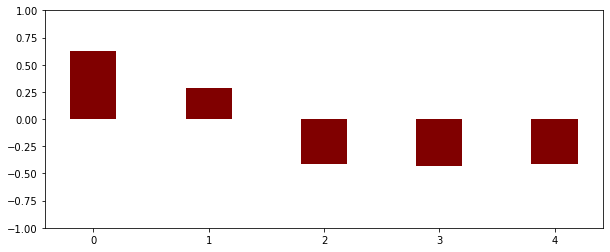

In [35]:
plot_coefs(erm_trainer.f.weight.detach()[0])

### RRM - all

In [53]:
# use all collected data 
print("RRM with all collected data:")
set_seed(seed)
delta = QuadraticCostDelta(None, cost, tau)
# create dist object from the samples that not included in the partial clean data
s_dist = SequentialDistribution(x1_dim, X_U[n_clean_train_samples:])
rrm_all_trainer = IterativeNonStrategicTrainer(f_fac, m_h_star, delta, s_dist, clean_data, n_features, x1_dim, n_samples_per_round, hinge_loss, use_only_x1=False)
rrm_all_trainer.train(time_steps, epochs, lr, batch_size, test_each_step=True, verbose=True, use_only_last_samples=False)

RRM with all collected data:
time step: 1
-----learning f
trained 35 epochs. val acc: 0.9166666666666666
TricyFeature: points above threshold: 0.887103259563446, mean dist from threshold of these points: 0.028715400025248528
	total move: 0.192, pos move (out of total move): 0.021, neg move (out of total move): 0.979,
	pos turn to neg (out of pos move): 0.1, neg turn to pos (out of neg move): 0.019189765458422176,
	 f.bias: -0.12
	Accuracy: 0.7215749296906389
TricyFeature: points above threshold: 0.9049999713897705, mean dist from threshold of these points: 0.025551440194249153
time step: 2
-----learning f
trained 28 epochs. val acc: 0.9194444444444444
TricyFeature: points above threshold: 0.887103259563446, mean dist from threshold of these points: 0.029032504186034203
	total move: 0.19, pos move (out of total move): 0.017, neg move (out of total move): 0.983,
	pos turn to neg (out of pos move): 0.125, neg turn to pos (out of neg move): 0.017241379310344827,
	 f.bias: -0.075
	Accuracy:

### RRM - last

In [66]:
# use last samples 
print("RRM with only last collected data:")
set_seed(seed)
delta = QuadraticCostDelta(None, cost, tau)
# create dist object from the samples that not included in the partial clean data
s_dist = SequentialDistribution(x1_dim, X_U[n_clean_train_samples:])
rrm_last_trainer = IterativeNonStrategicTrainer(f_fac, m_h_star, delta, s_dist, clean_data, n_features, x1_dim, n_samples_per_round, hinge_loss, use_only_x1=False)
rrm_last_trainer.train(time_steps, epochs, lr, batch_size, test_each_step=True, verbose=True, use_only_last_samples=True)

RRM with only last collected data:
time step: 1
-----learning f
trained 35 epochs. val acc: 0.9166666666666666
TricyFeature: points above threshold: 0.887103259563446, mean dist from threshold of these points: 0.028715400025248528
	total move: 0.192, pos move (out of total move): 0.021, neg move (out of total move): 0.979,
	pos turn to neg (out of pos move): 0.1, neg turn to pos (out of neg move): 0.019189765458422176,
	 f.bias: -0.12
	Accuracy: 0.7215749296906389
TricyFeature: points above threshold: 0.9049999713897705, mean dist from threshold of these points: 0.025551440194249153
time step: 2
-----learning f
trained 7 epochs. val acc: 0.6833333333333333
TricyFeature: points above threshold: 0.887103259563446, mean dist from threshold of these points: 0.022773535922169685
	total move: 0.07, pos move (out of total move): 0.006, neg move (out of total move): 0.994,
	pos turn to neg (out of pos move): 0.0, neg turn to pos (out of neg move): 0.0,
	 f.bias: 0.282
	Accuracy: 0.561671353957

### ERMc

In [67]:
# RRM using only x_c, using all collected samples
print("ERMc")
set_seed(seed)
delta = QuadraticCostDelta(None, x1_cost, tau)
# create dist object from the samples that not included in the partial clean data
s_dist = SequentialDistribution(x1_dim, X_U[n_clean_train_samples:])
erm_c_trainer = IterativeNonStrategicTrainer(x1_f_fac, m_h_star, delta, s_dist, X1_clean_data, n_features, x1_dim, n_samples_per_round, hinge_loss, use_only_x1=True)
erm_c_trainer.train(time_steps, epochs, lr, batch_size, test_each_step=True, verbose=True, use_only_last_samples=False)

ERMc
time step: 1
-----learning f
trained 39 epochs. val acc: 0.9133333333333333
TricyFeature: points above threshold: 0.887103259563446, mean dist from threshold of these points: 0.031864579766988754
	total move: 0.164, pos move (out of total move): 0.022, neg move (out of total move): 0.978,
	pos turn to neg (out of pos move): 0.3333333333333333, neg turn to pos (out of neg move): 0.0,
	 f.bias: 0.01
	Accuracy: 0.7271996785857774
TricyFeature: points above threshold: 0.9049999713897705, mean dist from threshold of these points: 0.02930254116654396
time step: 2
-----learning f
trained 30 epochs. val acc: 0.8972222222222223
TricyFeature: points above threshold: 0.887103259563446, mean dist from threshold of these points: 0.03165541589260101
	total move: 0.16, pos move (out of total move): 0.013, neg move (out of total move): 0.987,
	pos turn to neg (out of pos move): 0.6, neg turn to pos (out of neg move): 0.0,
	 f.bias: 0.039
	Accuracy: 0.723985536359984
TricyFeature: points above thr

### SERMr

In [69]:
# SERM f using only only x2
print("SERMr:")
f = x2_f_fac()
opt = Adam(f.parameters(), lr=lr)
delta = QuadraticCostDelta(f, x2_cost, tau)
serm_r_trainer = StrategicTrainer(f, delta, full_X2_train_dl, X2_val, Y_val, X2_test, Y_test, opt, hinge_loss, cost_scale=cost_scale)
serm_r_trainer.train(epochs, True)
serm_r_acc = test_strategic_only_X2_model(f, m_h_star, delta, X1_test, X2_test, U_test)

SERMr:
trained 9 epochs. val acc: 0.6565008025682183
TricyFeature: points above threshold: 0.887103259563446, mean dist from threshold of these points: 0.02079404518008232
TricyFeature: points above threshold: 1.0, mean dist from threshold of these points: 0.02079404518008232
	Accuracy: 0.6576938529529932


### SERM

In [29]:
# SERM f on full input
print("SERM:")
f = f_fac()
opt = Adam(f.parameters(), lr=lr)
delta = QuadraticCostDelta(f, cost, tau)
serm_trainer = StrategicTrainer(f, delta, full_train_dl, X_val, Y_val, X_test, Y_test, opt, hinge_loss, cost_scale=cost_scale)
serm_trainer.train(epochs, True)
serm_acc = test_strategic(f, m_h_star, delta, X_test, U_test, x1_dim)

SERM:
trained 12 epochs. val acc: 0.9052969502407705
TricyFeature: points above threshold: 0.887103259563446, mean dist from threshold of these points: 0.03443143516778946
	total move: 0.364, pos move (out of total move): 0.778, neg move (out of total move): 0.222,
	pos turn to neg (out of pos move): 0.20454545454545456, neg turn to pos (out of neg move): 0.004975124378109453,
	 f.bias: -1.741
	Accuracy: 0.8505423865006027


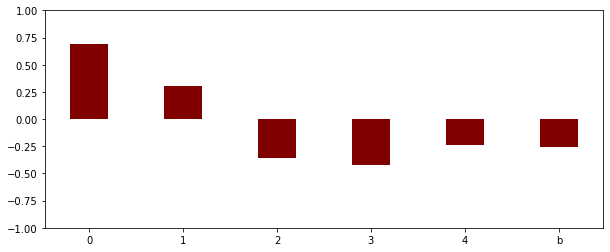

In [91]:
plot_coefs(serm_trainer.f.weight.detach()[0], bias=serm_trainer.f.bias.detach())

### RSRM - all

In [130]:
# RSRM using all collected data
print("RSRM with all collected data:")
set_seed(seed)
delta = QuadraticCostDelta(None, cost, tau)
# create dist object from the samples that not included in the partial clean data
s_dist = SequentialDistribution(x1_dim, X_U_train[n_clean_train_samples:])
rsrm_all_trainer = IterativeStrategicTrainer(f_fac, m_h_star, delta, s_dist, clean_data, n_features, x1_dim, n_samples_per_round, hinge_loss, cost_scale)
rsrm_all_trainer.train(time_steps, epochs, lr, batch_size, test_each_step=True, verbose=True, use_only_last_samples=False)

RSRM with all collected data:
time step: 1
-----learning f
trained 35 epochs. val acc: 0.9166666666666666
TricyFeature: points above threshold: 0.887103259563446, mean dist from threshold of these points: 0.02466941438615322
	total move: 0.205, pos move (out of total move): 0.629, neg move (out of total move): 0.371,
	pos turn to neg (out of pos move): 0.14330218068535824, neg turn to pos (out of neg move): 0.010582010582010581,
	 f.bias: -0.887
	Accuracy: 0.8806749698674167
TricyFeature: points above threshold: 0.9449999928474426, mean dist from threshold of these points: 0.025268426164984703
time step: 2
-----learning f
trained 37 epochs. val acc: 0.9333333333333333
TricyFeature: points above threshold: 0.887103259563446, mean dist from threshold of these points: 0.02457560785114765
	total move: 0.215, pos move (out of total move): 0.673, neg move (out of total move): 0.327,
	pos turn to neg (out of pos move): 0.11388888888888889, neg turn to pos (out of neg move): 0.0114285714285714

### RSRM - last

In [74]:
# RSRM using only last collected data
print("RSRM with only last collected data:")
set_seed(seed)
delta = QuadraticCostDelta(None, cost, tau)
# create dist object from the samples that not included in the partial clean data
s_dist = SequentialDistribution(x1_dim, X_U_train[n_clean_train_samples:])
rsrm_last_trainer = IterativeStrategicTrainer(f_fac, m_h_star, delta, s_dist, clean_data, n_features, x1_dim, n_samples_per_round, hinge_loss, cost_scale)
rsrm_last_trainer.train(time_steps, epochs, lr, batch_size, test_each_step=True, verbose=True, use_only_last_samples=True)

RSRM with only last collected data:
time step: 1
-----learning f
trained 35 epochs. val acc: 0.9166666666666666
TricyFeature: points above threshold: 0.887103259563446, mean dist from threshold of these points: 0.028595060110092163
	total move: 0.313, pos move (out of total move): 0.717, neg move (out of total move): 0.283,
	pos turn to neg (out of pos move): 0.11985688729874776, neg turn to pos (out of neg move): 0.01809954751131222,
	 f.bias: -1.113
	Accuracy: 0.8694254720771394
TricyFeature: points above threshold: 0.9449999928474426, mean dist from threshold of these points: 0.028867550194263458
time step: 2
-----learning f
trained 23 epochs. val acc: 0.7833333333333333
TricyFeature: points above threshold: 0.887103259563446, mean dist from threshold of these points: 0.03343179076910019
	total move: 0.278, pos move (out of total move): 0.471, neg move (out of total move): 0.529,
	pos turn to neg (out of pos move): 0.3619631901840491, neg turn to pos (out of neg move): 0.01092896174

### CSERM

In [48]:
print("ICSERM")
set_seed(seed)
delta = QuadraticCostDelta(None, cost, tau)
# create dist object from the samples that not included in the partial clean data
s_dist = SequentialDistribution(x1_dim, X_U_train[n_clean_train_samples:])
cserm_trainer = IterativeCausalStrategicTrainer(f_fac, h_fac, m_h_star, delta, s_dist, clean_data, x1_dim, x2_dim, n_samples_per_round, hinge_loss, cross_entropy_loss_for_h,
                                          exploration_params=None, should_estimate_density=True, pca=None, cost_scale=cost_scale)
cserm_trainer.train(time_steps, epochs, lr, lr, batch_size, verbose=True)

ICSERM
time step: 1
-----learning h
trained 19 epochs. val acc: 0.94
	Accuracy: 0.94

-----learning f
trained 9 epochs. val acc: 0.8314606741573034
trained 32 epochs. val acc: 0.9919743178170144
TricyFeature: points above threshold: 0.887103259563446, mean dist from threshold of these points: 0.0314328558743
	total move: 0.369, pos move (out of total move): 0.764, neg move (out of total move): 0.236,
	pos turn to neg (out of pos move): 0.15549215406562053, neg turn to pos (out of neg move): 0.004608294930875576,
	 f.bias: -1.483
	mean likelihood of moving points: 114.30300903320312
	Accuracy: 0.8585777420650864

-----collecting samples
time step: 2
-----learning h
trained 13 epochs. val acc: 0.925
	Accuracy: 0.925

-----learning f
trained 9 epochs. val acc: 0.8314606741573034
trained 38 epochs. val acc: 0.9919743178170144
TricyFeature: points above threshold: 0.887103259563446, mean dist from threshold of these points: 0.029676448553800583
	total move: 0.37, pos move (out of total move

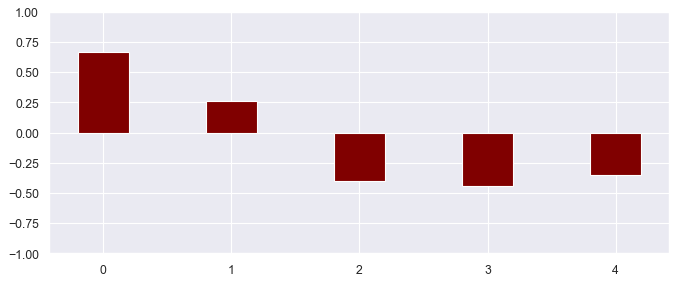

In [806]:
plot_coefs(cserm_trainer.f_list[0].weight.detach()[0])

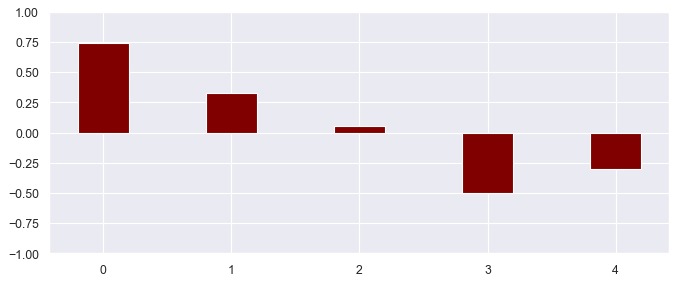

In [807]:
plot_coefs(cserm_trainer.f_list[-1].weight.detach()[0])

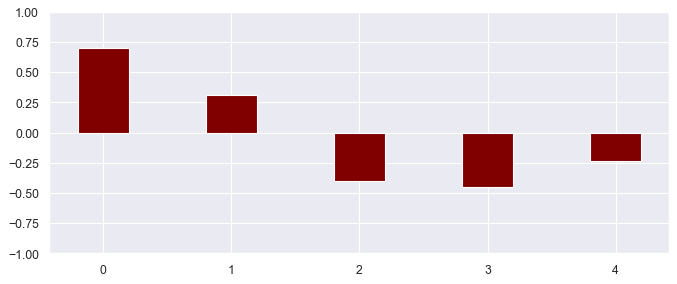

In [808]:
plot_coefs(serm_trainer.f.weight.detach()[0])

### CSERM with exploration

In [127]:
print("ICSERM with exploration")
set_seed(seed)
delta = QuadraticCostDelta(None, cost, tau)
exploration_params = ExplorationParams(should_use=True, coef=10, decay=0.4)
# create dist object from the samples that not included in the partial clean data
s_dist = SequentialDistribution(x1_dim, X_U_train[n_clean_train_samples:])
cserm_exp_trainer = IterativeCausalStrategicTrainer(f_fac, h_fac, m_h_star, delta, s_dist, clean_data, x1_dim, x2_dim, n_samples_per_round, hinge_loss, cross_entropy_loss_for_h,
                                          exploration_params=exploration_params, should_estimate_density=True, pca=None, cost_scale=cost_scale)
cserm_exp_trainer.train(time_steps, epochs, lr, lr, batch_size, verbose=True)

ICSERM with exploration
time step: 1
-----learning h
trained 13 epochs. val acc: 0.9
	Accuracy: 0.9

-----learning f
trained 26 epochs. val acc: 0.9004815409309791
trained 7 epochs. val acc: 0.6388443017656501
TricyFeature: points above threshold: 0.887103259563446, mean dist from threshold of these points: 0.058724742382764816
	total move: 0.293, pos move (out of total move): 0.07, neg move (out of total move): 0.93,
	pos turn to neg (out of pos move): 0.47058823529411764, neg turn to pos (out of neg move): 0.0,
	 f.bias: -0.524
	mean likelihood of moving points: 15.19389533996582
	Accuracy: 0.6267577340297308

-----collecting samples
time step: 2
-----learning h
trained 10 epochs. val acc: 0.9166666666666666
	Accuracy: 0.9166666666666666

-----learning f
trained 26 epochs. val acc: 0.9004815409309791
trained 16 epochs. val acc: 0.9004815409309791
TricyFeature: points above threshold: 0.887103259563446, mean dist from threshold of these points: 0.10771870613098145
	total move: 0.463, 

### CSERM-h*

In [37]:
print("CSERM with u and h*")
set_seed(seed)
f = f_fac()
opt = Adam(f.parameters(), lr=lr)
delta = QuadraticCostDelta(f, cost, tau)
helper = HelperModel(m_h_star)
cserm_h_star_trainer = CausalStrategicTrainerWithU(f, helper, delta, X_U_train_dl, full_train_dl, X_val, X_U_val, Y_val, X_test, n_features, x1_dim, opt, hinge_loss, cost_scale=cost_scale)
with HiddenPrints():
    cserm_h_star_trainer.train(epochs, False)
print("causal strategic f with h_star using u:")
cserm_h_star_acc = test_strategic(f, m_h_star, delta, X_test, U_test, x1_dim)

CSERM with u and h*
causal strategic f with h_star using u:
TricyFeature: points above threshold: 0.887103259563446, mean dist from threshold of these points: 0.01968924142420292
	total move: 0.377, pos move (out of total move): 0.736, neg move (out of total move): 0.264,
	pos turn to neg (out of pos move): 0.0, neg turn to pos (out of neg move): 0.3911290322580645,
	 f.bias: -2.092
	Accuracy: 0.9284853354760948


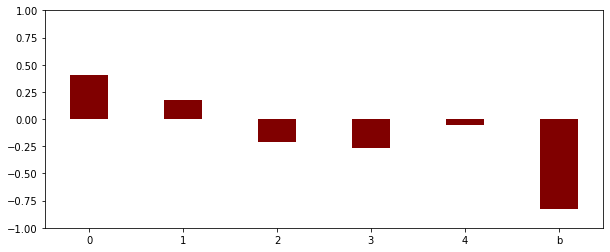

In [115]:
plot_coefs(cserm_h_star_trainer.f.weight.detach()[0], bias=cserm_h_star_trainer.f.bias.detach())

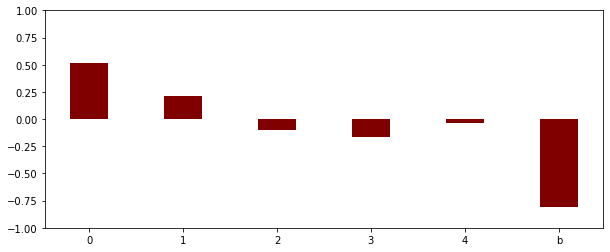

In [90]:
plot_coefs(cserm_h_star_trainer.f.weight.detach()[0], bias=cserm_h_star_trainer.f.bias.detach())